In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from xgboost import XGBRegressor, XGBRFRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
from sklearn.dummy import DummyRegressor
from copy import deepcopy
import shap
import datetime

sns.set(rc={'figure.figsize':(16,9)})


# 0.1 Global  Variables

Section reserved for global/config variables 


In [2]:
METRICS = [mean_squared_error, mean_absolute_percentage_error]
SCORING = "neg_mean_absolute_percentage_error"

# 0.2 Functions Definition 

Section reserved for functions that will be used through the jupyter file


In [3]:
def cross_train(models,cv,X_train,Y_train):
    best_model_score = -np.inf
    best_model = None
    for idx,(name,model) in enumerate(models):
        result = cross_val_score(model, X_train, Y_train,  scoring=SCORING, cv=cv)
        names.append(name)
        results.append(result)
        if result.mean() > best_model_score:
            best_model = idx
            best_model_score = result.mean()
            

    for i in range(len(names)):
        print(names[i],results[i].mean())
     
    
    print("Best Model:", names[best_model])
    return best_model

def infer(model, X_test):
    
    inference_results = []
    y_pred = model.predict(X_test)
    

    return y_pred

def smape(target, preds):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

METRICS.append(smape)


# 1. Temporal K-Fold 

As we are dealing with temporal data, we can't use the standard K-Fold methodology to validate our model. The problem with standard K-Fold is the **Data Leakage** (Usage of training data *after* the test data) and unnatural behavior of the model, we can't use future to predict the past. Therefore, we have to use a special K-Fold technique to validate our model **Temporal K-Fold**

In [4]:
df = pd.read_csv("./dataset/primary.csv")
df

,date,count,day,count_lag_1,count_lag_2,count_lag_3,count_lag_4,count_lag_5,count_lag_6,count_lag_7,...,month_9,month_10,month_11,month_12,week_of_the_month_0,week_of_the_month_1,week_of_the_month_2,week_of_the_month_3,week_of_the_month_4,week_of_the_month_5
0,2015-06-01,39,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
1,2015-06-02,49,2,39.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
2,2015-06-03,46,3,49.0,39.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
3,2015-06-04,28,4,46.0,49.0,39.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
4,2015-06-05,40,5,28.0,46.0,49.0,39.0,NaN,NaN,NaN,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670,2019-12-27,37,27,42.0,14.0,33.0,44.0,21.0,34.0,50.0,...,0,0,0,1,0,0,0,0,1,0
1671,2019-12-28,27,28,37.0,42.0,14.0,33.0,44.0,21.0,34.0,...,0,0,0,1,0,0,0,0,1,0
1672,2019-12-29,15,29,27.0,37.0,42.0,14.0,33.0,44.0,21.0,...,0,0,0,1,0,0,0,0,1,0
1673,2019-12-30,23,30,15.0,27.0,37.0,42.0,14.0,33.0,44.0,...,0,0,0,1,0,0,0,0,0,1


**We will remove 2019 in our data, because it will our out-of-sample data to test our model**

In [5]:
df["date"] = pd.to_datetime(df["date"])
train, test = df[df["date"].dt.year < 2019],df[df["date"].dt.year >= 2019]

In [6]:
train.shape

(1310, 69)

In [7]:
test

,date,count,day,count_lag_1,count_lag_2,count_lag_3,count_lag_4,count_lag_5,count_lag_6,count_lag_7,...,month_9,month_10,month_11,month_12,week_of_the_month_0,week_of_the_month_1,week_of_the_month_2,week_of_the_month_3,week_of_the_month_4,week_of_the_month_5
1310,2019-01-01,14,1,16.0,13.0,18.0,43.0,32.0,27.0,13.0,...,0,0,0,0,1,0,0,0,0,0
1311,2019-01-02,33,2,14.0,16.0,13.0,18.0,43.0,32.0,27.0,...,0,0,0,0,1,0,0,0,0,0
1312,2019-01-03,29,3,33.0,14.0,16.0,13.0,18.0,43.0,32.0,...,0,0,0,0,1,0,0,0,0,0
1313,2019-01-04,23,4,29.0,33.0,14.0,16.0,13.0,18.0,43.0,...,0,0,0,0,1,0,0,0,0,0
1314,2019-01-05,26,5,23.0,29.0,33.0,14.0,16.0,13.0,18.0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670,2019-12-27,37,27,42.0,14.0,33.0,44.0,21.0,34.0,50.0,...,0,0,0,1,0,0,0,0,1,0
1671,2019-12-28,27,28,37.0,42.0,14.0,33.0,44.0,21.0,34.0,...,0,0,0,1,0,0,0,0,1,0
1672,2019-12-29,15,29,27.0,37.0,42.0,14.0,33.0,44.0,21.0,...,0,0,0,1,0,0,0,0,1,0
1673,2019-12-30,23,30,15.0,27.0,37.0,42.0,14.0,33.0,44.0,...,0,0,0,1,0,0,0,0,0,1


In [8]:
cv = TimeSeriesSplit(10)

In [9]:
# Creating expanding windows 
[(el[0].shape, el[1].shape) for el in cv.split(train)]

[((120,), (119,)),
 ((239,), (119,)),
 ((358,), (119,)),
 ((477,), (119,)),
 ((596,), (119,)),
 ((715,), (119,)),
 ((834,), (119,)),
 ((953,), (119,)),
 ((1072,), (119,)),
 ((1191,), (119,))]

In [10]:
# Creating model
xgb = XGBRegressor()
X_train = train.drop(columns=["date","count"]).values
Y_train = train["count"].values
X_test = test.drop(columns=["date","count"]).values
Y_test = test["count"].values

In [11]:
%%time
cv_scores = cross_val_score(xgb, X_train, Y_train, cv=cv, 
                            scoring=SCORING, n_jobs=1) 

CPU times: user 33.5 s, sys: 60.9 ms, total: 33.6 s
Wall time: 3.15 s


In [12]:
cv_scores, cv_scores.mean()

(array([-0.36455083, -0.46240373, -0.27590307, -0.19881295, -0.31193501,
        -0.20510137, -0.29093712, -0.25890438, -0.37815769, -0.25350498]),
 -0.300021113301684)

**Seems that all things are working. Next section will develop a model selection based on multiple models and multiple metrics. This test above is only a sanity check** 

# 2. Model Selection 

## Conclusions

It seems that LGBM performs better than other algorithms in cross-validation. Although, the other algorithms are close to the LGBM, with difference less than 0.1, we have to pick one to understand the most importante features.  A DummyRegressor was added only for baselines. MAPE shows 24% error and we can use this metric as principal metric because we do not have 0 values on test and neither extreme values. 

In [13]:
models = []
results = []
names = []

models.append(("XGBoostRF",XGBRFRegressor()))
models.append(("XGBoost",XGBRegressor()))
models.append(("LGBM",LGBMRegressor()))
models.append(("CatBoost",CatBoostRegressor(silent=True)))
models.append(("DummyRegressorMean", DummyRegressor(strategy="mean")))

In [14]:
winner = cross_train(models,cv,X_train,Y_train)

XGBoostRF -0.2973368482949419
XGBoost -0.300021113301684
LGBM -0.29543210465172065
CatBoost -0.2957550689593118
DummyRegressorMean -0.3954595668013417
Best Model: LGBM


**Fit the best model with the whole data**

In [15]:
model_fitted = models[winner][1].fit(X_train,Y_train)

In [16]:
preds = infer(model_fitted, X_test)

## 2.1 Measure results 

In [17]:
metric_results = []
for metric in METRICS:
    metric_value = metric(Y_test, preds)
    metric_results.append(metric_value)

In [18]:
df = pd.DataFrame(data=[metric_results], columns=[metric.__name__ for metric in METRICS])

In [19]:
df["model"] = models[winner][0]
df

,mean_squared_error,mean_absolute_percentage_error,smape,model
0,75.270992,0.240852,21.094886,LGBM


**Seems like LGBM with random forest has the best result regarding forecasting year 2019**

In [20]:
compare_df = test[["count"]]
compare_df["label"] = "True"
compare_df["day"] = pd.date_range("2019-01-01", "2019-12-31", freq="d")
compare_df


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,count,label,day
1310,14,True,2019-01-01
1311,33,True,2019-01-02
1312,29,True,2019-01-03
1313,23,True,2019-01-04
1314,26,True,2019-01-05
...,...,...,...
1670,37,True,2019-12-27
1671,27,True,2019-12-28
1672,15,True,2019-12-29
1673,23,True,2019-12-30


In [21]:
df_result = pd.DataFrame(columns=["count","label","day"])
df_result["count"] = preds
df_result["label"] = models[winner][0]
df_result["day"] = pd.date_range("2019-01-01", "2019-12-31", freq="d")
    
df_total_result = pd.concat([compare_df,df_result],ignore_index=True)
df_total_result

,count,label,day
0,14.000000,True,2019-01-01
1,33.000000,True,2019-01-02
2,29.000000,True,2019-01-03
3,23.000000,True,2019-01-04
4,26.000000,True,2019-01-05
...,...,...,...
725,32.970074,LGBM,2019-12-27
726,23.276949,LGBM,2019-12-28
727,18.547169,LGBM,2019-12-29
728,27.956541,LGBM,2019-12-30


In [22]:
df_total_result.set_index("day").groupby("label").resample("W").mean().reset_index()

,label,day,count
0,LGBM,2019-01-06,30.090249
1,LGBM,2019-01-13,27.013378
2,LGBM,2019-01-20,29.121975
3,LGBM,2019-01-27,28.938439
4,LGBM,2019-02-03,30.050424
...,...,...,...
101,True,2019-12-08,50.714286
102,True,2019-12-15,41.571429
103,True,2019-12-22,41.000000
104,True,2019-12-29,30.285714


<AxesSubplot:xlabel='day', ylabel='count'>

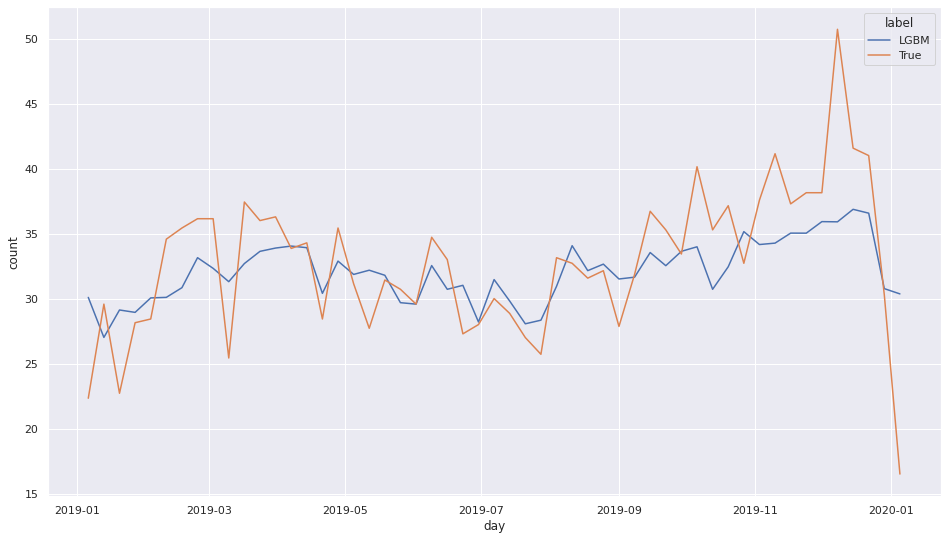

In [23]:
sns.lineplot(data=df_total_result.set_index("day").groupby("label").resample("W").mean().reset_index(), x="day", y="count", hue="label")

# 3 Interpretation - Shap

In this section we will see the importance/shap value for each one of the 10 top most importante features. This gave us the power to interpret the model and make some analysis related to results. We will choose only the best model according to the calculed metrics above

## Conclusions

- Seems that feature is_weekend is the most important feature
    - When is_weekend is high (bool == 1) we have less accidents. Probably people spend more time on their houses and don't have to commute to the work (Less cars in the strees)
- Day of the week 6(Sunday), same as above but for a specific day.
- Day of the year shows that high values, more accidents. It the trends we see before on data exploration. In the second semester we have more holidays, probably people drink more and as we said before, alcohool and drink do not mix well.
- Count Lag 1 (t-1), when day before has a high number of accident, we have more accidents in a day t. Probably because an street or avenue have a problem or maybe hidden road sign.
- count_lag_28 is 4 weeks before

In [24]:
explainer = shap.TreeExplainer(model_fitted)
Xd = xgboost.DMatrix(X_train, label=Y_train)
shap_values = explainer.shap_values(X_train)

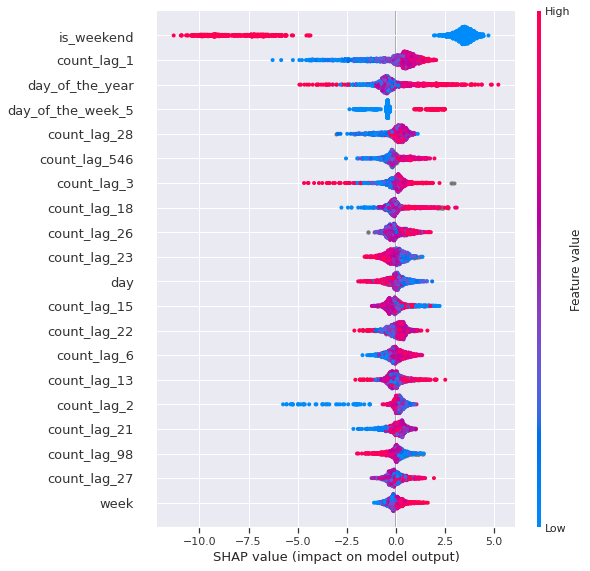

In [25]:
shap.summary_plot(shap_values, train.drop(columns=["date","count"]))

# 4. Model Degradation 

In this section, we will measure how much time is necessary to model lose its quality/performance. We will use all the training dataset to fit the model and create a test set with monthly gap. First gap we will be zero, so we do not have interval between training and testing datasets. Next iteration gap == 1, so we will jump one month and pick next ones and creating testing set, until we see a big degradation on metrics we are evaluating. 

## Conclusions

In the final of 5 months, model degrades approximate 10% related to mase metric. The right time to retrain the model, or a upper bound for degradation, is related to business problem, infrastructure and computional cost for it. 

In [26]:
if winner == 0:
    model_not_yet_fitted = XGBRFRegressor()
if winner == 1:
    model_not_yet_fitted = XGBRegressor()
if winner == 2:
    model_not_yet_fitted = LGBMRegressor()
if winner == 3:
    model_not_yet_fitted = CatBoostRegressor()

In [27]:
month_result = []
for i in range(1,6+1):
    date_begin = datetime.datetime(2019, i, 1)
    model = deepcopy(model_not_yet_fitted)
    model_fitted = model.fit(X_train,Y_train)
    X_test = test[(test.date >= date_begin)].drop(columns=["date","count"]).values
    Y_test = test[(test.date >= date_begin)]["count"].values
    preds = infer(model_fitted, X_test)
    metric_value = mean_absolute_percentage_error(Y_test, preds)
    month_result.append(tuple([i-1,metric_value]))

In [28]:
df_degradation = pd.DataFrame.from_records(month_result,columns=["gap","mape"])
df_degradation

,gap,mape
0,0,0.240852
1,1,0.234113
2,2,0.236164
3,3,0.223103
4,4,0.221332
5,5,0.215008


<AxesSubplot:xlabel='gap', ylabel='mape'>

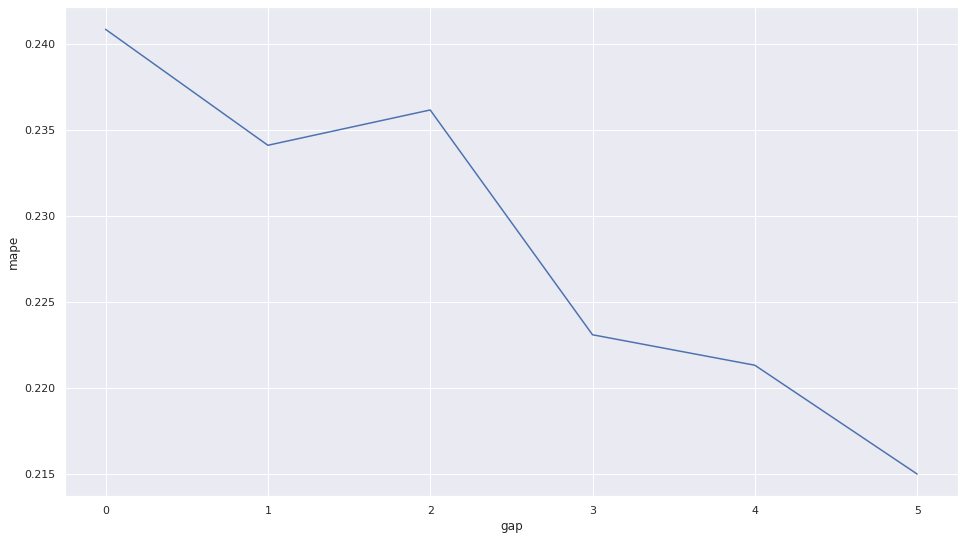

In [29]:
sns.lineplot(data=df_degradation,x="gap",y="mape")

# 5. Next Steps

- Use differentation and log transformation on data and remove the small trend on series. (Can improve the model a little)
    - They are simple and can easily return to original values
- Create models for specific parts of the day
    - It is possible it has more accidents on rush hours.
- Test autoregressive models like ARIMA or Prophet 
- Create models for each region(South, Southeast and etc) as we have neighborhood data available. 
- Imputation to use other models 
- Use a feature selection technique to improve model